In [363]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as sk_r2_score
from sklearn import preprocessing

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [433]:
PTH = './data.csv'
TEST_SIZE = 0.2
LR = 0.01
BATCH_SIZE = 796 #len(d)*0.8
EPOCHS = 500

In [324]:
def string_to_float(feature):
    l = d[feature].unique()
    l_dict = dict(zip(l, np.arange(0.0, len(l))))
    return l_dict 

In [385]:
def preprocess(d): 
    clean_language = string_to_float('language')
    clean_license = string_to_float('license')
    d = d.drop(columns=['private', 'url', 'Unnamed: 0'])
    d['language'] = d['language'].apply(lambda x: clean_language[x])
    d['license'] = d['license'].apply(lambda x: clean_license[x])
    #d = d.drop(columns=['watchers'])

    print(d.head())
    
    X = d.drop(columns=['stars']).values
    y = d['stars'].values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
    
    
    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.FloatTensor(y_train)
    y_val = torch.FloatTensor(y_val)

    return X_train, X_val, y_train, y_val

In [386]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=10, out_features=72)
        self.fc2 = nn.Linear(in_features=72, out_features=72)
        self.fc3 = nn.Linear(in_features=72, out_features=36)
        self.fc4 = nn.Linear(in_features=36, out_features=18)
        self.fc5 = nn.Linear(in_features=18, out_features=9)
        self.output = nn.Linear(in_features=9, out_features=1)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.output(x)
        return x

In [387]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [388]:
def train(model, criterion, optimizer):
    epochs = EPOCHS
    loss_arr = []

    for i in range(epochs):

        permutation = torch.randperm(X_train.size()[0])
        
        for j in range(0,X_train.size()[0], BATCH_SIZE):
            
            indices = permutation[j:j+BATCH_SIZE]
            batch_x, batch_y = X_train[indices], y_train[indices]
            
            y_hat = model.forward(batch_x)
            loss = criterion(batch_y, y_hat)
            loss_arr.append(loss.detach().numpy())

        if i % 100 == 0:
            print(f'Epoch: {i} Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    plt.title('Loss VS Epoch')
    plt.xlabel("Loss")
    plt.xlabel("Epoch")
    plt.plot(loss_arr)

In [389]:
def get_r2_score(model):
    preds = []
    with torch.no_grad():
        for val in X_val:
            y_hat = model.forward(val)
            preds.append(y_hat)
    preds = torch.FloatTensor(preds)
    return r2_loss(y_val, preds)

In [390]:
def get_r2_score_sk(model):
    preds = []
    with torch.no_grad():
        for val in X_val:
            y_hat = model.forward(val)
            preds.append(y_hat)
    #preds = np.array(preds, dtype=np.float32)
    return sk_r2_score(y_val, preds)

In [391]:
def get_accuracy(model):
    preds = []
    with torch.no_grad():
        for val in X_val:
            y_hat = model.forward(val)
            preds.append(round(y_hat.numpy()[0]))
    y_val_int = [int(y) for y in y_val.numpy()]
    df = pd.DataFrame({'Y': y_val_int, 'YHat': preds})
    df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]
    print(df.head(n=10))
    return df['Correct'].sum() / len(df)

In [392]:
d = pd.read_csv(PTH)
X_train, X_val, y_train, y_val = preprocess(d)

    stars  forks  language    size  subscribers  network  issues  watchers  \
0  346019  28631         0  315892         8471    28631     145    346019   
1  195821  32118         1   27949         6126    32118     569    195821   
2  191817  22142         2    5423         3527    22142       1    191817   
3  187981  38681         1  178526         6635    38681     924    187981   
4  164934  86752         3  896271         7860    86752    2417    164934   

   pulls  commits  license  
0     27    30441        0  
1    242     3227        1  
2      0     4525        1  
3    250    14974        1  
4    202   129325        2  


/Users/manelmateos/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([796, 1])) that is different to the input size (torch.Size([796])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 25610.775390625
Epoch: 100 Loss: 15433.134765625
Epoch: 200 Loss: 14875.0703125
Epoch: 300 Loss: 14300.9072265625
Epoch: 400 Loss: 13828.5751953125


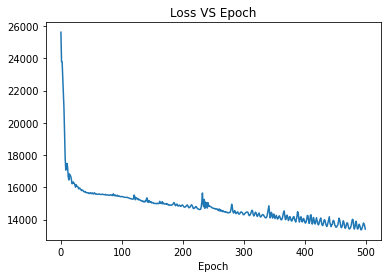

In [434]:
model = NN()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train(model, criterion, optimizer)

In [437]:
r2_score = get_r2_score(model)
acc = get_accuracy(model)

print(f'r2 score is: {r2_score}')
print(f'accuracy is: {acc}')

       Y   YHat  Correct
0  13114  18050        0
1  18211  26108        0
2  17600  18373        0
3  16255  21473        0
4  16724  18477        0
5  20034  23273        0
6  13734  20314        0
7  15514  15352        0
8  32750  30208        0
9  17138  12676        0
r2 score is: 0.7536057233810425
accuracy is: 0.0


/Users/manelmateos/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([796, 1])) that is different to the input size (torch.Size([796])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 13319.419921875
Epoch: 100 Loss: 13057.0234375
Epoch: 200 Loss: 12923.4599609375
Epoch: 300 Loss: 13034.0380859375
Epoch: 400 Loss: 13186.6591796875


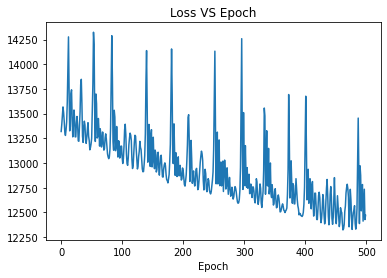

In [436]:
train(model, criterion, optimizer)

In [438]:
def save_model(model, d_pth):
    torch.save(model.state_dict(), d_pth)

In [ ]:
d_pth='model.pth'